# NN5: Testowanie różnych funkcji aktywacji
## Laura Hoang, 313366

Należy rozszerzyć istniejącą implementację sieci i metody uczącej o możliwość wyboru funkcji aktywacji:
- sigmoid,
- liniowa,
- tanh,
- ReLU.

Pytanie dodatkowe – czy wszyscy implementują dokładnie gradient dla funkcji ReLU?

Porównać szybkość uczenia i skuteczność sieci w zależności od liczby neuronów w poszczególnych warstwach i rodzaju funkcji aktywacji. Należy wziąć pod uwagę fakt, że różne funkcje aktywacji mogą dawać różną skuteczność w zależności od liczby neuronów i liczby warstw. Sprawdzić sieci z jedną, dwiema i trzema warstwami ukrytymi. **Podobnie jak w poprzednim tygodniu, trzeba dostosować proces uczenia do pochodnych nowych funkcji aktywacji.**

Przeprowadzić testy wstępne dla zbioru multimodal-large (regresja), dla wszystkich trzech architektur i wszystkich czterech funkcji aktywacji.

Dla pozostałych zbiorów wybrać dwa najlepsze zestawy i zbadać ich skuteczność:
- regresja
    - steps-large,
- klasyfikacja
    - rings5-regular
    - rings3-regular.

## Importowanie bibliotek

In [1]:
import pandas as pd
import numpy as np
from numpy import dot
from scipy.special import expit
import matplotlib
from matplotlib import pyplot as plt
# import sklearn.metrics
from sklearn.metrics import log_loss

np.random.seed(420)

## Implementacja sieci

### Funkcje aktywacji

W tej pracy pojawiają się 3 nowe funkcje aktywacji (wraz z ich gradientami):
- `linear` - liniowa
- `tanh`
- `relu` - ReLU.

#### Pytanie dodatkowe – czy wszyscy implementują dokładnie gradient dla funkcji ReLU?
Nie implementuje się dokładnie gradientu dla tej funkcji, ponieważ nie różniczkuje się w 0. Co więcej, niektórzy dla x < 0 dają pochodną równą 0.01, aby dalej pomimo aktywacji zerowej gradient nie został wyzerowany.

In [2]:
# SIGMOID
def sigmoid(x):
    return expit(x)     # wersja stabilna numerycznie

def sigmoid_der(x):     # pochodna sigmoid
    return sigmoid(x) * (1 - sigmoid(x))


# LINIOWA
def linear(x):
    return np.array(np.nan_to_num(x))
    # return np.array(x)

def linear_der(x):      # pochodna linear
    return np.ones(x.shape)


# TANH
def tanh(x):
    return np.tanh(x)

def tanh_der(x):      # pochodna tanh
    return np.nan_to_num(1/np.cosh(x)**2)


# ReLU
def relu(x):
    z = np.array(x)    
    return np.maximum(0,z)

def relu_der(x):      # pochodna ReLU
    z = np.array(x)
    z[z<0] = 0
    z[z!=0] = 1
    return z


## KLASYFIKACJA
# SOFTMAX
def softmax(x):
    e_x = np.exp(x.T - np.max(x, axis=1).T).T
    return (e_x.T / e_x.sum(axis=1).T).T

### Metryki

In [3]:
## REGRESJA
# błąd średniowkadratowy
def mse(y, y_hat):
    return np.square(np.subtract(y, y_hat)).mean()

## KLASYFIKACJA
def TP(y,y_hat):
    vals = np.unique(y)
    result = []
    for v in vals:
        result += [[(a==b)and(b==v) for (a,b) in zip(y,y_hat)]]
    return result

def FP(y,y_hat):
    vals = np.unique(y)
    result = []
    for v in vals:
        result += [[(a!=b)and(b==v) for (a,b) in zip(y,y_hat)]]
    return result

def FN(y,y_hat):
    vals = np.unique(y)
    result = []
    for v in vals:
        result += [[(a!=b)and(a==v) for (a,b) in zip(y,y_hat)]]
    return result

# Precision = tp / (tp + fp)
def precision(y,y_hat):
    tp = TP(y,y_hat)
    fp = FP(y,y_hat)
    sum_tp = sum([sum(x) for x in tp])
    sum_fp = sum([sum(x) for x in fp])
    return sum_tp / (sum_tp + sum_fp)

# Recall = tp / (tp + fn)
def recall(y,y_hat):
    tp = TP(y,y_hat)
    fn = FN(y,y_hat)
    sum_tp = sum([sum(x) for x in tp])
    sum_fn = sum([sum(x) for x in fn])
    return sum_tp / (sum_tp + sum_fn)

# Poor F-Measure score is 0.0 and a best or perfect F-Measure score is 1.0
# F-Measure = (2 * Precision * Recall) / (Precision + Recall)
def f_measure(y,y_hat):
    pre = precision(y,y_hat)
    rec = recall(y,y_hat)
    return (2 * pre * rec) / (pre + rec)

### Sieć neuronowa

In [4]:
class NeuralNetwork():
    def __init__(self, number_of_neurons=[], activation_function_name="sigmoid", initiate_w_b="Uniform", use_softmax=False, visualize_weights=False):
        self.number_of_neurons = number_of_neurons      # liczba neuronów w każdej warstwie (wliczając wejście i wyjście)
        self.activation_function_name = activation_function_name  # nazwa funkcji aktywacji
        self.synaptic_weights = []                      # lista z wagami
        self.biases = []                                # lista biasów

        if self.activation_function_name == "linear":
            self.activation_function = linear
            self.activation_function_der = linear_der
        elif self.activation_function_name == "tanh":
            self.activation_function = tanh
            self.activation_function_der = tanh_der
        elif self.activation_function_name == "relu":
            self.activation_function = relu
            self.activation_function_der = relu_der
        else:  # "sigmoid"
            self.activation_function = sigmoid
            self.activation_function_der = sigmoid_der


        if initiate_w_b == "Xavier":
            self.weights_xavier(number_of_neurons)
        else:  # uniform
            self.weights_uniform(number_of_neurons)

        self.use_softmax = use_softmax
        self.visualize_weights = visualize_weights


    def weights_uniform(self, number_of_neurons):
        for i in range(len(self.number_of_neurons) - 1):
            self.synaptic_weights += [np.random.uniform(-1, 1, self.number_of_neurons[i] * self.number_of_neurons[i + 1]).reshape(number_of_neurons[i], self.number_of_neurons[i + 1])]
            self.biases += [np.random.uniform(-1, 1, self.number_of_neurons[i + 1]).reshape(1, self.number_of_neurons[i+1])]


    def weights_xavier(self, number_of_neurons):
        xavier = np.sqrt(6)/np.sqrt(self.number_of_neurons[1]+self.number_of_neurons[-1])
        for i in range(len(self.number_of_neurons) - 1):
            self.synaptic_weights += [xavier * np.random.uniform(-1, 1, self.number_of_neurons[i] * self.number_of_neurons[i + 1]).reshape(number_of_neurons[i], self.number_of_neurons[i + 1])]
            self.biases += [xavier * np.random.uniform(-1, 1, self.number_of_neurons[i + 1]).reshape(1, self.number_of_neurons[i+1])]


    def forward(self, input):
        self.A = []
        self.z = []

        self.A += [input]
        a = input

        number_of_hidden_layers = len(self.number_of_neurons)-2
        for layer in range(number_of_hidden_layers):
            output = dot(a, self.synaptic_weights[layer]) + self.biases[layer]
            self.z += [output]
            a = self.activation_function(output)
            self.A += [np.nan_to_num(a)]
            # self.A += [a]
        result = np.nan_to_num(dot(a,self.synaptic_weights[-1]) + self.biases[-1])
        # result = dot(a,self.synaptic_weights[-1]) + self.biases[-1]

        if self.use_softmax:
            result = softmax(result)

        self.z += [result]
        self.A += [result]

        return result


    def backward(self, y):
        m = y.shape[0]
        D = [None] * len(self.synaptic_weights)

        if self.use_softmax:
            tmp = []
            for a,y_ in zip(self.A[-1], y):
                error = y_-a
                a_ = a.reshape(a.shape[0], )
                si_sj = - a_ * a_.reshape(self.number_of_neurons[-1], 1)
                sof_der = np.diag(a_) + si_sj
                tmp += [dot(sof_der,error)]
            tmp = np.array(tmp)
            D[-1] = tmp
        else:
            # D[-1] = (y - self.A[-1]) * self.activation_function_der(self.A[-1])
            D[-1] = (y - self.A[-1])

        for i in reversed(range(len(D) - 1)):
            D[i] = (dot(self.synaptic_weights[i + 1], D[i + 1].T) * self.activation_function_der(self.z[i]).T).T

        delta_w = [None] * len(D)
        delta_b = [None] * len(D)

        for i, d in enumerate(D):
            delta_w[i] = dot(d.T, self.A[i]).T / m
            delta_b[i] = dot(d.T, np.ones((m, 1))).T / m

        return (delta_w, delta_b)


    def train(self, x, y, batch_size=20, epochs=500, alpha=0.1, method = "Classic", var=0.5):
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]

        method_w = [np.zeros(w.shape) for w in self.synaptic_weights]
        method_b = [np.zeros(b.shape) for b in self.biases]

        for epoch in range(epochs):
            i = 0

            while i < len(y):
                x_batch = x[i : i+batch_size]
                y_batch = y[i : i+batch_size]

                i += batch_size
                
                self.forward(x_batch)
                (delta_w, delta_b) = self.backward(y_batch)

                if method == "Classic":
                    for j, weight in enumerate(self.synaptic_weights):
                        self.synaptic_weights[j] = weight + alpha * delta_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        self.biases[j] = bias + alpha * delta_b[j]
                
                elif method == "Momentum":
                    for j, weight in enumerate(self.synaptic_weights):    
                        method_w[j] = method_w[j] * var + delta_w[j]
                        self.synaptic_weights[j] = weight + alpha * method_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = method_b[j] * var + delta_b[j]
                        self.biases[j] = bias + alpha * method_b[j]
                        
                elif method == "RMSProp":
                    for j, weight in enumerate(self.synaptic_weights):
                        method_w[j] = var * method_w[j] + (1-var) * delta_w[j] ** 2
                        self.synaptic_weights[j] = weight + alpha * (delta_w[j]/np.sqrt(method_w[j]) + 10**-8)
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = var * method_b[j] + (1-var) * delta_b[j] ** 2
                        self.biases[j] = bias + alpha * (delta_b[j]/np.sqrt(method_b[j]) + 10**-8)
            
            # BADANIE SKUTECZNOŚCI MODELU DLA KOLEJNYCH ITERACJI (epoch)
            if self.visualize_weights:
                if epoch % 50 == 0:
                    print("Error in epoch {} = {}".format(epoch, np.linalg.norm(self.A[-1] - y_batch)))
            else:
                if self.use_softmax:
                    print(' ', end='\r')
                    # print(f"Cross entropy loss in epoch {epoch} = {log_loss(np.argmax(y_batch, axis =1), self.A[-1])}", end='\r')
                else:
                    print(f"Custom error in epoch {epoch} = { np.abs(y_batch -  self.A[-1]).mean()}", end='\r')

    def classify(self,x):
        probability = self.forward(x)
        return [i.argmax() for i in probability]



### Wizualizacje

In [5]:
def plot_train_test(x, y, x_test, y_test, classification=False, c=None, c_test=None):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Zbiór treningowy vs. testowy')
    fig.set_size_inches(10,4)

    if classification:
        colors = ['pink','lightgreen','lightblue']
        ax1.scatter(x, y, c=c, cmap=matplotlib.colors.ListedColormap(colors))
        ax2.scatter(x_test, y_test, c=c_test, cmap=matplotlib.colors.ListedColormap(colors))
    else:
        ax1.plot(x, y, 'o', markersize=3)
        ax2.plot(x_test, y_test, 'o', markersize=3)


def plot_compare_pred(x, y, y_pred=None, classification=False, c=None, c_pred=None):
    if classification:
        fig = plt.figure(figsize=(10,8))

        colors = ['pink','lightgreen','lightblue']

        plt.subplot(2, 2, 1)
        plt.scatter(x, y, c=c, cmap=matplotlib.colors.ListedColormap(colors))
        plt.suptitle('Oryginalny podział', fontsize=10)

        plt.subplot(2, 2, 2)
        plt.scatter(x, y, c=c_pred, cmap=matplotlib.colors.ListedColormap(colors))
        plt.suptitle('Predykcja', fontsize=10)

        plt.title(f'F-measure: {f_measure(c, c_pred)}', fontsize=7)

    else:
        fig = plt.figure(figsize=(5,4))

        plt.scatter(x, y, s=10)
        plt.scatter(x, y_pred, s=6)
        plt.suptitle('Oryginał vs. predykcja', fontsize=10)
        plt.title(f'MSE: {mse(y, y_pred)}', fontsize=7)

    plt.show()



### Funkcje pomocnicze

In [6]:
def one_hot(c):
    unique_vals = np.unique(c)
    tmp=[]
    for val in unique_vals:
        tmp += [((c==val)*1).tolist()]
    return tmp

## Testy wstępne (zbiór danych *multimodal-large*)
Na początku przeprowadzone zostaną testy wstępne na zbiorze *multimodal-large* - przetestowane zostaną wszystkie funkcje aktywacji i 3 warianty architektur: z 1, 2 i 3 warstwami ukrytymi.

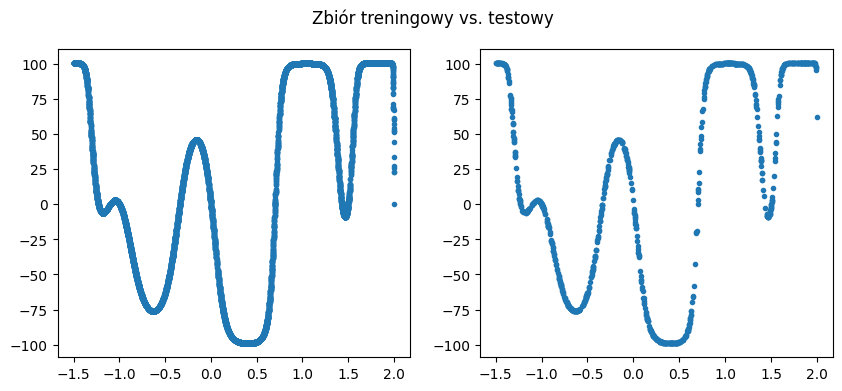

In [7]:
train_df = pd.read_csv('multimodal-large-training.csv')
test_df = pd.read_csv('multimodal-large-test.csv')

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

plot_train_test(x,y,x_test,y_test)

### Testowanie funkcji `sigmoid`

--------------- Architektura: [1, 16, 1] ----------------------


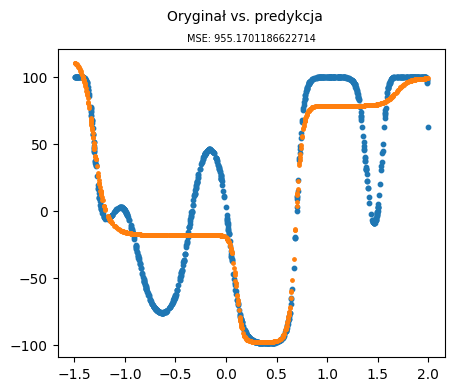

--------------- Architektura: [1, 32, 16, 1] ----------------------


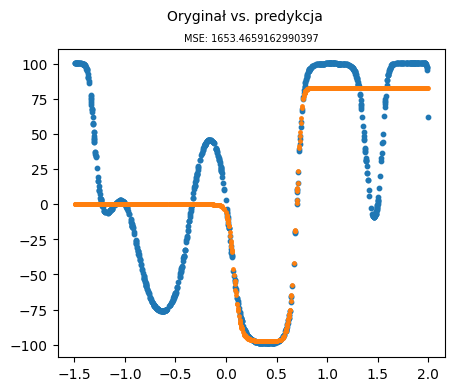

--------------- Architektura: [1, 32, 32, 16, 1] ----------------------


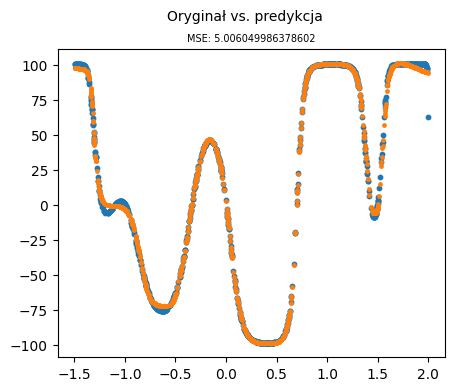

In [8]:
architectures = [[1, 16, 1], [1, 32, 16, 1], [1, 32, 32, 16, 1]]
epochs = 200

for arch in architectures:
    print('--------------- Architektura:', arch, '----------------------')
    nn = NeuralNetwork(number_of_neurons = arch, activation_function_name = "sigmoid", initiate_w_b = "Uniform", use_softmax=False, visualize_weights=False)
    nn.train(x, y, epochs=epochs, batch_size = 20, alpha=0.001, method = "Classic")
    y_pred = nn.forward(x_test)
    plot_compare_pred(x_test,y_test,y_pred,False)


Dla `sigmoid` zdecydowanie najlepiej sprawdziła się architektura z 3 warstwami.

### Testowanie funkcji `linear`

--------------- Architektura: [1, 16, 1] ----------------------


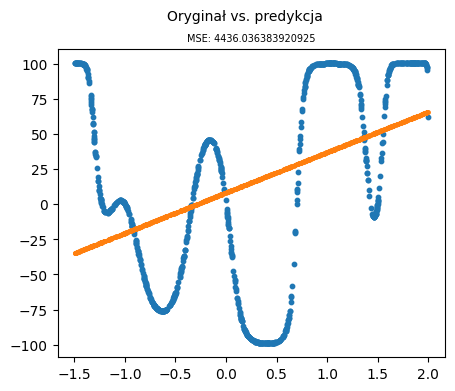

--------------- Architektura: [1, 32, 16, 1] ----------------------


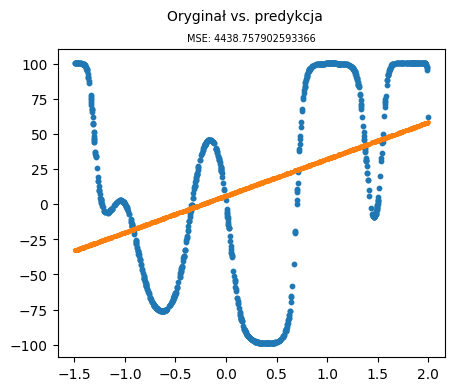

--------------- Architektura: [1, 32, 32, 16, 1] ----------------------


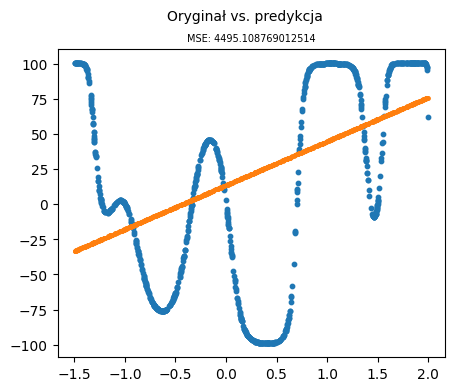

In [9]:
architectures = [[1, 16, 1], [1, 32, 16, 1], [1, 32, 32, 16, 1]]
epochs = 200

for arch in architectures:
    print('--------------- Architektura:', arch, '----------------------')
    nn = NeuralNetwork(number_of_neurons = arch, activation_function_name = "linear", initiate_w_b = "Uniform", use_softmax=False, visualize_weights=False)
    nn.train(x, y, epochs=epochs, batch_size = 20, alpha=0.001, method = "Classic")
    y_pred = nn.forward(x_test)
    plot_compare_pred(x_test,y_test,y_pred,False)


W prawie każdym przypadku funkcja linowa osiąga ten sam wynik, co wynika z tego, że aktywacja liniowa nie modyfikuje nam kształtu naszej predykowanej funkcji (tzn. możemy ją zapisać w postaci y = ax + b niezależnie od liczby neuronów). Stąd takie wyniki i taki sposób dopasowania modelu.

### Testowanie funkcji `tanh`

--------------- Architektura: [1, 16, 1] ----------------------


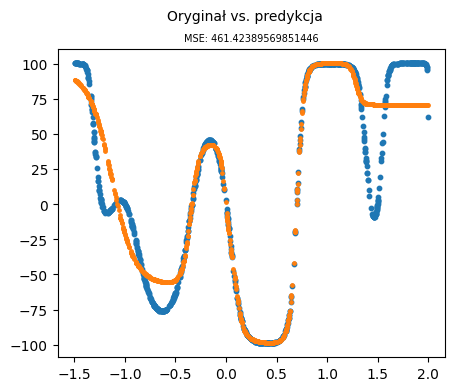

--------------- Architektura: [1, 32, 16, 1] ----------------------


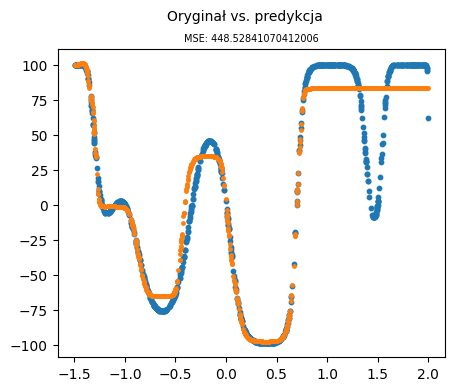

--------------- Architektura: [1, 32, 32, 16, 1] ----------------------


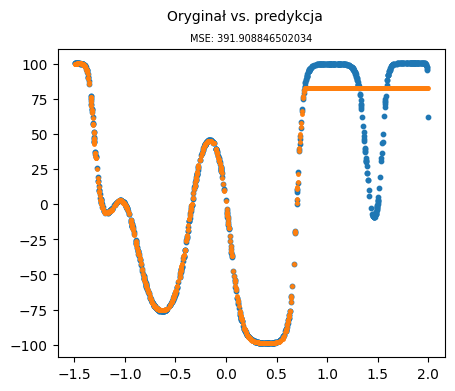

In [10]:
architectures = [[1, 16, 1], [1, 32, 16, 1], [1, 32, 32, 16, 1]]
epochs = 200

for arch in architectures:
    print('--------------- Architektura:', arch, '----------------------')
    nn = NeuralNetwork(number_of_neurons = arch, activation_function_name = "tanh", initiate_w_b = "Uniform", use_softmax=False, visualize_weights=False)
    nn.train(x, y, epochs=epochs, batch_size = 20, alpha=0.001, method = "Classic")
    y_pred = nn.forward(x_test)
    plot_compare_pred(x_test,y_test,y_pred,False)


Podobnie jak dla `sigmoid` najlepiej sprawdza się architektura z 3 warstwami.

### Testowanie funkcji `ReLU`

--------------- Architektura: [1, 16, 1] ----------------------


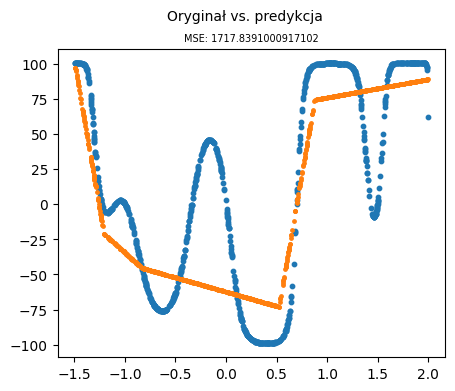

--------------- Architektura: [1, 32, 16, 1] ----------------------


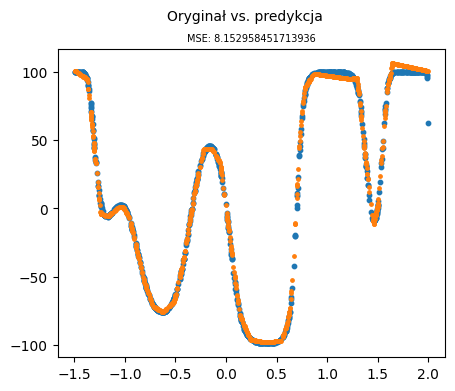

--------------- Architektura: [1, 32, 32, 16, 1] ----------------------


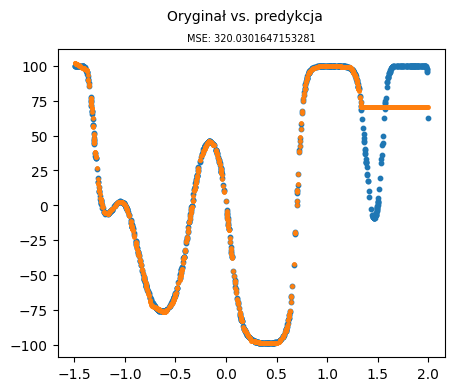

In [11]:
architectures = [[1, 16, 1], [1, 32, 16, 1], [1, 32, 32, 16, 1]]
epochs = 200

for arch in architectures:
    print('--------------- Architektura:', arch, '----------------------')
    nn = NeuralNetwork(number_of_neurons = arch, activation_function_name = "relu", initiate_w_b = "Uniform", use_softmax=False, visualize_weights=False)
    nn.train(x, y, epochs=epochs, batch_size = 20, alpha=0.001, method = "Classic")
    y_pred = nn.forward(x_test)
    plot_compare_pred(x_test,y_test,y_pred,False)


W tym wypadku najlepiej wypadły 2 warstwy ukryte.

## Pierwszy zbiór danych (regresja: *steps-large*)
Dla tego zbioru sprawdziły się najlepiej te same architektury co dla *multimodal-large*:
- sigmoid [1, 32, 32, 16, 1]
- ReLU [1, 32, 16, 1]

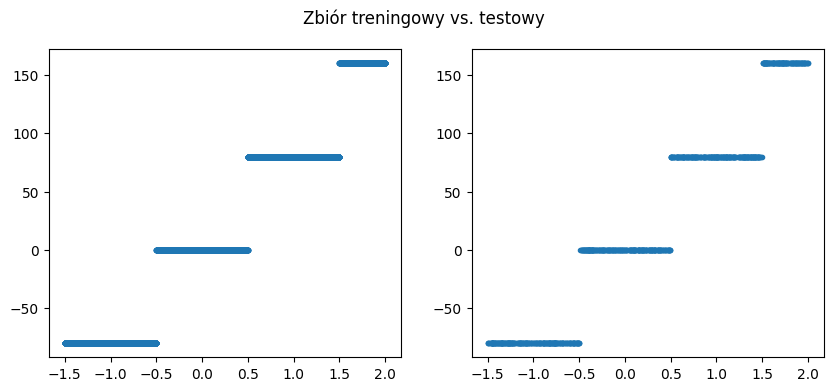

In [23]:
train_df = pd.read_csv('steps-large-training.csv', index_col=0)
test_df = pd.read_csv('steps-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

plot_train_test(x,y,x_test,y_test)

--------------- Architektura: [1, 32, 32, 16, 1] ----------------------


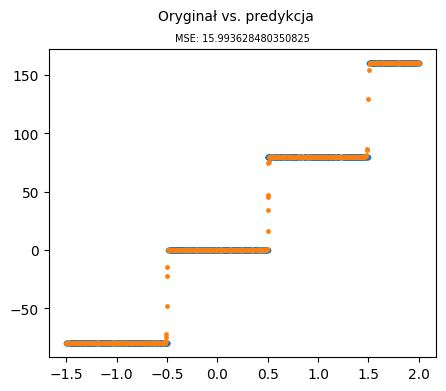

In [24]:
arch = [1, 32, 32, 16, 1]
epochs = 1000

print('--------------- Architektura:', arch, '----------------------')
nn = NeuralNetwork(number_of_neurons = arch, activation_function_name = "sigmoid", initiate_w_b = "Uniform", use_softmax=False, visualize_weights=False)
nn.train(x, y, epochs=epochs, batch_size = 20, alpha=0.001, method = "Classic")
y_pred = nn.forward(x_test)
plot_compare_pred(x_test,y_test,y_pred,False)


--------------- Architektura: [1, 32, 16, 1] ----------------------


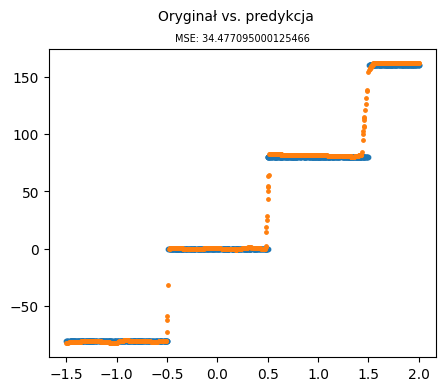

In [26]:
arch = [1, 32, 16, 1]
epochs = 500

print('--------------- Architektura:', arch, '----------------------')
nn = NeuralNetwork(number_of_neurons = arch, activation_function_name = "relu", initiate_w_b = "Uniform", use_softmax=False, visualize_weights=False)
nn.train(x, y, epochs=epochs, batch_size = 20, alpha=0.001, method = "Classic")
y_pred = nn.forward(x_test)
plot_compare_pred(x_test,y_test,y_pred,False)


## Drugi zbiór danych (klasyfikacja: *rings3-regular*)
Dla zbiorów do klasyfikacji należało dobrać inne architektury. W przypadku tego zbioru najlepeij wypadły:
- sigmoid [2, 64, 64, 3]
- tanh [2, 64, 64, 3]

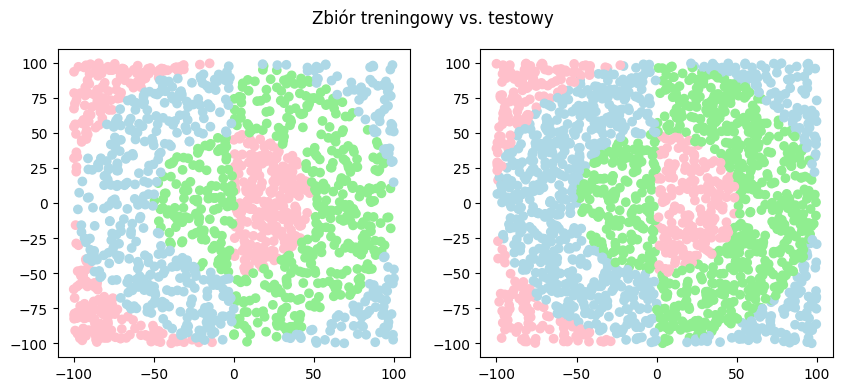

In [15]:
train_df = pd.read_csv('rings3-regular-training.csv')
test_df = pd.read_csv('rings3-regular-test.csv')

plot_train_test(train_df['x'], train_df['y'], test_df['x'], test_df['y'], classification=True, c=train_df['c'], c_test=test_df['c'])

In [16]:
x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])

c = np.asarray(train_df['c'])
c_test = np.asarray(test_df['c'])

encoded = np.array(one_hot(c)).T

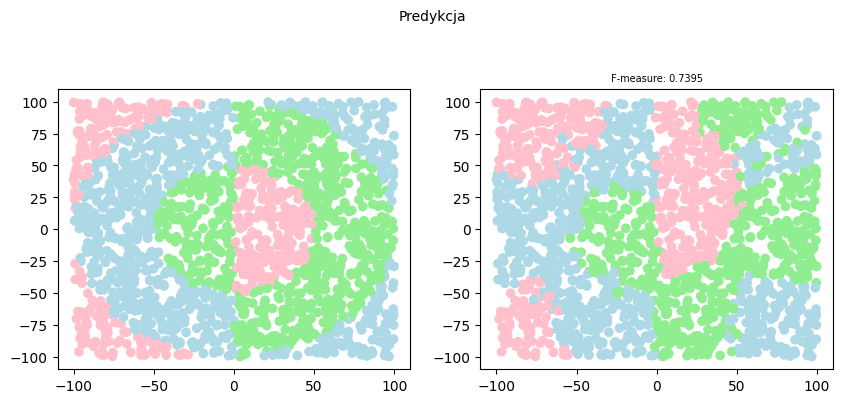

In [17]:
arch = [2, 64, 64, 3]
epochs = 1000

nn = NeuralNetwork(number_of_neurons = arch, activation_function_name = "sigmoid", initiate_w_b = "Uniform", use_softmax=True, visualize_weights=False)
nn.train(x=x, y=encoded, epochs=epochs, alpha=0.01)

plot_compare_pred(test_df['x'], test_df['y'], y_pred=None, classification=True, c=test_df['c'], c_pred=nn.classify(x_test))

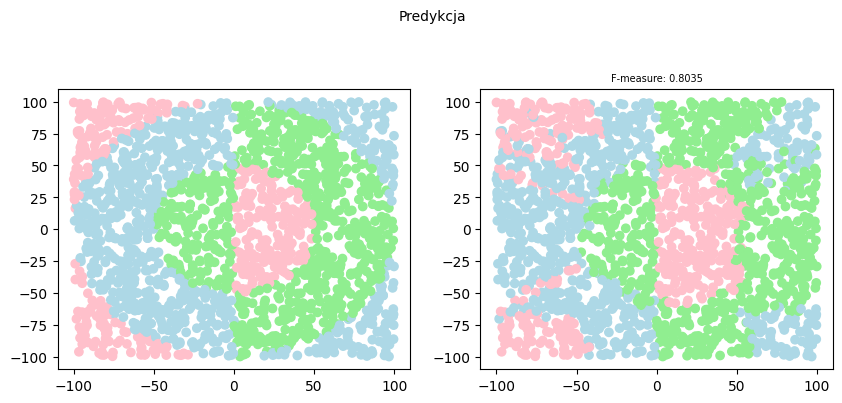

In [18]:
arch = [2, 64, 64, 3]
epochs = 1000

nn = NeuralNetwork(number_of_neurons = arch, activation_function_name = "tanh", initiate_w_b = "Uniform", use_softmax=True, visualize_weights=False)
nn.train(x=x, y=encoded, epochs=epochs, alpha=0.01)

plot_compare_pred(test_df['x'], test_df['y'], y_pred=None, classification=True, c=test_df['c'], c_pred=nn.classify(x_test))

## Trzeci zbiór danych (klasyfikacja: *rings5-regular*)
W przypadku tego zbioru najlepiej wpadły:
- sigmoid [2, 50, 50, 5]
- ReLU [2, 10, 5]

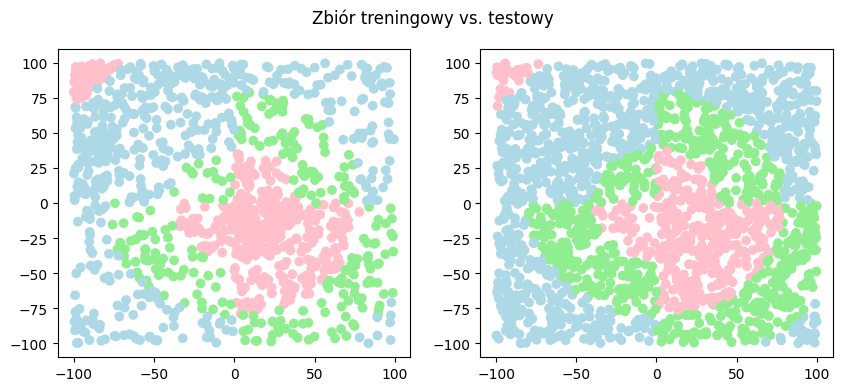

In [19]:
train_df = pd.read_csv('rings5-regular-training.csv')
test_df = pd.read_csv('rings5-regular-test.csv')

plot_train_test(train_df['x'], train_df['y'], test_df['x'], test_df['y'], classification=True, c=train_df['c'], c_test=test_df['c'])

In [20]:
x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])

c = np.asarray(train_df['c'])
c_test = np.asarray(test_df['c'])

encoded = np.array(one_hot(c)).T

--------------- Architektura: [2, 50, 50, 5] ----------------------


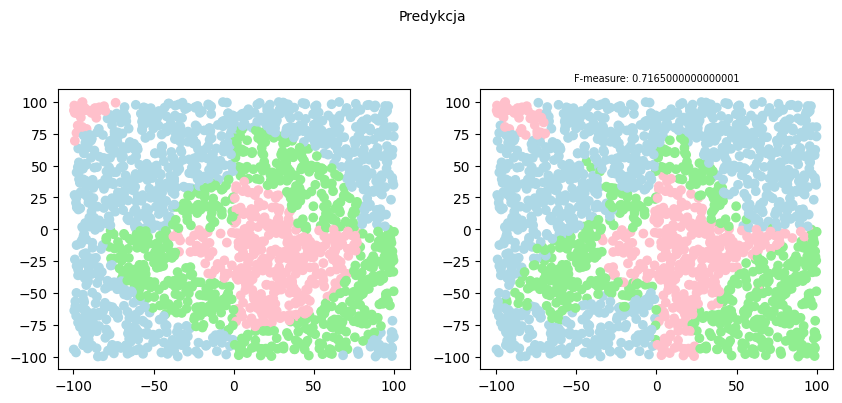

In [21]:
arch = [2, 50, 50, 5]
# arch = [2, 64, 64, 5]

epochs = 1000

print('--------------- Architektura:', arch, '----------------------')
nn = NeuralNetwork(number_of_neurons = arch, activation_function_name = "sigmoid", initiate_w_b = "Uniform", use_softmax=True, visualize_weights=False)
nn.train(x=x, y=encoded, epochs=epochs, alpha=0.01, method="Momentum", var=0.8)

plot_compare_pred(test_df['x'], test_df['y'], y_pred=None, classification=True, c=test_df['c'], c_pred=nn.classify(x_test))

--------------- Architektura: [2, 10, 5] ----------------------


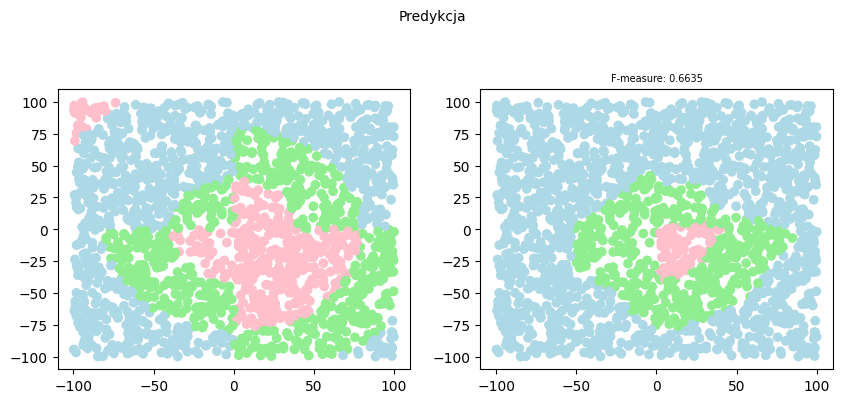

In [22]:
arch = [2, 10, 5]

epochs = 1000

print('--------------- Architektura:', arch, '----------------------')
nn = NeuralNetwork(number_of_neurons = arch, activation_function_name = "relu", initiate_w_b = "Uniform", use_softmax=True, visualize_weights=False)
nn.train(x=x, y=encoded, epochs=epochs, alpha=0.01, method="Momentum", var=0.8)

plot_compare_pred(test_df['x'], test_df['y'], y_pred=None, classification=True, c=test_df['c'], c_pred=nn.classify(x_test))

## Podsumowanie

*(regresja)*

MSE w testach wstępnych:
|         | 1-16-1 | 1-32-16-1 | 1-32-32-16-1 |
|---------|-------|---------|-----------|
| sigmoid | 955.1 | 27.8 | 1.13 |
| linear | 4436 | 4438.7 | 4495.1 |
| tanh | 461.4 | 448.5 | 391.9 |
| ReLU | 1717.8 | 8.15 | 320 |


MSE na zbiorze *steps-large*:
- sigmoid, 1-32-32-16-1: **15.9**
- ReLU, 1-32-16-1: **34.4**


*(klasyfikacja)*

F-measure na *rings3-regular*:
- sigmoid 2-64-64-3*: **0.73**
- tanh 2-64-64-3*: **0.8**

F-measure na *rings5-regular*:
- sigmoid 2-50-50-5*: **0.71**
- ReLU 2-10-5*: **0.66**

Skuteczność modeli jest badana poprzez outputy w implementacji sieci: gdy parametr `visualize_weights=True`, to outputy te zostają wyspiane.
Jednak, aby praca była bardziej przejrzysta, to parametr ten ma ustawioną wartość `False`, ale przy wywoływaniu kodu nadal wypisują się outputy, jednak każdy kolejny będzie znikał (zostanie tylko ostatni).
Outputy w tym przypadku są w postaci różnic między predykcjami w kolejnych epochach, a prawdziwymi wartościami. Dzięki temu nadal można analizować skuteczność modeli.

*pierwsza i ostatnia warstwa to wejście i wyjście